In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [52]:
df = pd.read_csv('Toddler Autism dataset July 2018.csv')
df.head()

,Case_No,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD,Who completed the test,Class/ASD Traits
0,1,0,0,0,0,0,0,1,1,0,1,28,3,f,middle eastern,yes,no,family member,No
1,2,1,1,0,0,0,1,1,0,0,0,36,4,m,White European,yes,no,family member,Yes
2,3,1,0,0,0,0,0,1,1,0,1,36,4,m,middle eastern,yes,no,family member,Yes
3,4,1,1,1,1,1,1,1,1,1,1,24,10,m,Hispanic,no,no,family member,Yes
4,5,1,1,0,1,1,1,1,1,1,1,20,9,f,White European,no,yes,family member,Yes


In [53]:
df.columns = [x.lower().strip() for x in df.columns]

df = df.rename(columns={'age_mons':'age_months','qchat-10-score':'qchat_score','family_mem_with_asd':'asd_history',
                        'who completed the test':'completed_test','class/asd traits':'asd_traits'})

df = df.drop(columns=['case_no','completed_test','asd_traits'])

In [54]:
df['jaundice'] = df['jaundice'].map({'yes':1,'no':0})
df['asd_history'] = df['asd_history'].map({'yes':1,'no':0})
df['sex'] = df['sex'].map({'m':1,'f':0})

In [55]:
df['ethnicity'].value_counts()

White European    334
asian             299
middle eastern    188
south asian        60
black              53
Hispanic           40
Others             35
Latino             26
mixed               8
Pacifica            8
Native Indian       3
Name: ethnicity, dtype: int64

In [56]:
df['ethnicity'] = [x.lower() for x in df['ethnicity']]
df['ethnicity'] = df['ethnicity'].replace({'latino':'hispanic',
                                           'mixed':'others',
                                           'pacifica':'others',
                                           'native indian':'others'})

In [57]:
# Create new binary variable column for qchat_score: 1 = ASD, 0 = no ASD
df['potential_asd'] = [1 if x > 3 else 0 for x in df['qchat_score']]

In [58]:
df['potential_asd'].value_counts()

1    728
0    326
Name: potential_asd, dtype: int64

In [59]:
for col in range(10):
    print(df.iloc[:,col].value_counts())

1    594
0    460
Name: a1, dtype: int64
0    581
1    473
Name: a2, dtype: int64
0    631
1    423
Name: a3, dtype: int64
1    540
0    514
Name: a4, dtype: int64
1    553
0    501
Name: a5, dtype: int64
1    608
0    446
Name: a6, dtype: int64
1    685
0    369
Name: a7, dtype: int64
0    570
1    484
Name: a8, dtype: int64
0    538
1    516
Name: a9, dtype: int64
1    618
0    436
Name: a10, dtype: int64


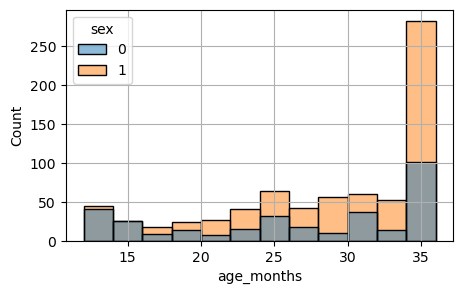

In [60]:
plt.figure(figsize=(5,3))
sns.histplot(data=df, x='age_months', hue='sex')
plt.grid()

# Model building

In [61]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [62]:
FEATURES = ['age_months','sex','ethnicity','jaundice','asd_history']
TARGET = ['potential_asd']

X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Logistic Regression

In [13]:
column_trans = make_column_transformer(
    (OneHotEncoder(), ['ethnicity']),
    remainder='passthrough')

log = LogisticRegression(random_state=1)

pipe = make_pipeline(column_trans, log)

cross_val_score(pipe, X, y, cv=5).mean()

0.6973098623335591

In [14]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['ethnicity'])])),
                ('logisticregression', LogisticRegression(random_state=1))])

In [16]:
y_pred = pipe.predict(X_test)

In [17]:
pipe.score(X_test, y_test)

0.6966824644549763

### Logistic Regression (with GridSearchCV)

In [18]:
column_trans = make_column_transformer(
    (OneHotEncoder(), ['ethnicity']),
    remainder='passthrough')

log = LogisticRegression(random_state=1)

pipe = make_pipeline(column_trans, log)

params = {
    'columntransformer__onehotencoder__drop': [None, 'first'],
    'logisticregression__penalty': ['l1','l2'],
    'logisticregression__C': [1,10] 
}

grid = GridSearchCV(pipe, params, cv=5, scoring='accuracy')

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['ethnicity'])])),
                                       ('logisticregression',
                                        LogisticRegression(random_state=1))]),
             param_grid={'columntransformer__onehotencoder__drop': [None,
                                                                    'first'],
                         'logisticregression__C': [1, 10],
                         'logisticregression__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [19]:
print(grid.best_params_)
print(grid.best_score_)
df_log = pd.DataFrame(grid.cv_results_)

{'columntransformer__onehotencoder__drop': None, 'logisticregression__C': 1, 'logisticregression__penalty': 'l2'}
0.6951394759087066


In [20]:
df_log[['rank_test_score','mean_test_score','params']].sort_values('rank_test_score')

,rank_test_score,mean_test_score,params
1,1,0.695139,{'columntransformer__onehotencoder__drop': Non...
3,1,0.695139,{'columntransformer__onehotencoder__drop': Non...
5,3,0.693949,{'columntransformer__onehotencoder__drop': 'fi...
7,3,0.693949,{'columntransformer__onehotencoder__drop': 'fi...
0,5,NaN,{'columntransformer__onehotencoder__drop': Non...
2,5,NaN,{'columntransformer__onehotencoder__drop': Non...
4,5,NaN,{'columntransformer__onehotencoder__drop': 'fi...
6,5,NaN,{'columntransformer__onehotencoder__drop': 'fi...


### Random Forest

In [21]:
column_trans = make_column_transformer(
    (OneHotEncoder(), ['ethnicity']),
    remainder='passthrough')

forest = RandomForestClassifier(random_state=1)

pipe = make_pipeline(column_trans, forest)

params = {
'columntransformer__onehotencoder__drop': [None, 'first'],
'randomforestclassifier__max_depth': list(range(3,7))
}

grid = GridSearchCV(pipe, params, cv=5, scoring='accuracy')

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['ethnicity'])])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=1))]),
             param_grid={'columntransformer__onehotencoder__drop': [None,
                                                                    'first'],
                         'randomforestclassifier__max_depth': [3, 4, 5, 6]},
             scoring='accuracy')

In [22]:
print(grid.best_params_)
print(grid.best_score_)
df_forest = pd.DataFrame(grid.cv_results_)

{'columntransformer__onehotencoder__drop': None, 'randomforestclassifier__max_depth': 6}
0.7129261763877148


In [23]:
df_forest[['rank_test_score','mean_test_score','params']].sort_values('rank_test_score')

,rank_test_score,mean_test_score,params
3,1,0.712926,{'columntransformer__onehotencoder__drop': Non...
5,2,0.711729,{'columntransformer__onehotencoder__drop': 'fi...
6,3,0.708171,{'columntransformer__onehotencoder__drop': 'fi...
4,4,0.704614,{'columntransformer__onehotencoder__drop': 'fi...
7,5,0.703438,{'columntransformer__onehotencoder__drop': 'fi...
2,6,0.703438,{'columntransformer__onehotencoder__drop': Non...
0,7,0.703423,{'columntransformer__onehotencoder__drop': Non...
1,8,0.702254,{'columntransformer__onehotencoder__drop': Non...


### XG Boost

In [24]:
column_trans = make_column_transformer(
    (OneHotEncoder(), ['ethnicity']),
    remainder='passthrough')

xgb = XGBClassifier(n_estimators=200)

pipe = make_pipeline(column_trans, xgb)

params = {
    'columntransformer__onehotencoder__drop': [None, 'first'],
    'xgbclassifier__learning_rate': [0.001,0.01,0.1],
    'xgbclassifier__max_depth': list(range(3,7)),
    'xgbclassifier__gamma': [0.001,0.01,0.1],
}

grid = RandomizedSearchCV(pipe, params, n_iter=10, cv=5, scoring='accuracy')

grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(),
                                                                               ['ethnicity'])])),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            early_stopping_rounds=None,
                                                            ena...
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            n_estimators=200,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            predictor=None,
                                                            random_state=None, ...))]),
                   param_distributions={'columntransformer__onehotencoder__drop': [None,
                                                                                   'first'],
                                        'xgbclassifier__gamma': [0.001, 0.01,
                                                                 0.1],
                                        'xgbclassifier__learning_rate': [0.001,
                                                                         0.01,
                                                                         0.1],
                                        'xgbclassifier__max_depth': [3, 4, 5,
                                                                     6]},
                   scoring='accuracy')

In [25]:
print(grid.best_params_)
print(grid.best_score_)
df_xgb = pd.DataFrame(grid.cv_results_)

{'xgbclassifier__max_depth': 4, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__gamma': 0.001, 'columntransformer__onehotencoder__drop': None}
0.7129402648633418


In [26]:
df_xgb[['rank_test_score','mean_test_score','params']].sort_values('rank_test_score')

,rank_test_score,mean_test_score,params
3,1,0.712940,"{'xgbclassifier__max_depth': 4, 'xgbclassifier..."
7,2,0.711700,"{'xgbclassifier__max_depth': 6, 'xgbclassifier..."
0,3,0.703466,"{'xgbclassifier__max_depth': 3, 'xgbclassifier..."
4,4,0.703438,"{'xgbclassifier__max_depth': 6, 'xgbclassifier..."
9,5,0.701028,"{'xgbclassifier__max_depth': 4, 'xgbclassifier..."
2,6,0.697542,"{'xgbclassifier__max_depth': 5, 'xgbclassifier..."
5,6,0.697542,"{'xgbclassifier__max_depth': 3, 'xgbclassifier..."
6,8,0.697499,"{'xgbclassifier__max_depth': 3, 'xgbclassifier..."
8,9,0.696344,"{'xgbclassifier__max_depth': 4, 'xgbclassifier..."
1,10,0.691582,"{'xgbclassifier__max_depth': 6, 'xgbclassifier..."


In [ ]:
# {'xgbclassifier__max_depth': 4, 
#     'xgbclassifier__learning_rate': 0.01, 
#     'xgbclassifier__gamma': 0.001, 
#     'columntransformer__onehotencoder__drop': None}
# 0.7129402648633418

In [63]:
column_trans = make_column_transformer(
    (OneHotEncoder(drop=None), ['ethnicity']),
    remainder='passthrough')

xgb = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.01, gamma=0.001)

pipe = make_pipeline(column_trans, xgb)

pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['ethnicity'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               f...gamma=0.001, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.01,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=4, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=200, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, ...))])

In [72]:
from sklearn.metrics import precision_score, recall_score, classification_report

y_pred = pipe.predict(X_test)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.419     0.224     0.292        58
           1      0.750     0.882     0.811       153

    accuracy                          0.701       211
   macro avg      0.585     0.553     0.551       211
weighted avg      0.659     0.701     0.668       211

